In [492]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import src
from src.utils import TSTrendEstimator, plot_TSTrendEstimation

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
import cufflinks
cufflinks.go_offline()

from pathlib import Path
from random import choice

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def shap2coord(point):
    if point is None or point.is_empty:
        return None
    return np.asarray(point.xy).reshape(2)
    
def norm(vec):
    if vec is None:
        return None
    return np.linalg.norm(vec)


# LOAD DATA

In [512]:
path = '../data/decoded_forward/'
files = list(Path(path).glob('*.csv'))

# rand_file = choice(files)
print(rand_file)

df = pd.read_csv(rand_file, usecols=['car_vin', 'time', 'lat', 'lon', 'speed'])
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df = df.loc[~df.car_vin.isna()]
df = df.groupby('car_vin').resample('10s').mean()
print(df.shape)

../data/decoded_forward/trucks_telemetry_forward-000450_decode.csv
(34601, 3)


![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Circle_radians.gif/300px-Circle_radians.gif)

# SCORE PROCESSING

### SPHERE COORDINATES TO CARTESIAN

In [515]:
geometry = [Point(x, y) for x,y in zip(df['lon'], df['lat'])]
crs = {'init': 'epsg:4326'}  #WGS84
df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
df.to_crs(epsg=3576, inplace=True)

### ANGLE CULCULATION

In [516]:
df['vector'] = df['geometry'].apply(shap2coord)
df['vector'] = df.groupby('car_vin')['vector'].diff()
df['vector_lag'] = df.groupby('car_vin')['vector'].shift()

df['angle'] = (df['vector_lag']/df['vector_lag'].apply(norm))*(df['vector']/df['vector'].apply(norm))
df['angle'] = df['angle'].apply(np.sum)
df.drop(['vector', 'vector_lag'], axis=1, inplace=True)

In [536]:
df

lat        lon  speed  \
car_vin            time                                               
XTC5490005У2447718 2020-05-25 17:36:10  55.727791  52.483513    8.0   
                   2020-05-25 17:36:20  55.727691  52.483793    9.6   
                   2020-05-25 17:36:30  55.727904  52.484262   10.0   
                   2020-05-25 17:36:40  55.728101  52.484460    9.9   
                   2020-05-25 17:36:50  55.728291  52.484818   10.0   
...                                           ...        ...    ...   
Z9M93403350246953  2020-05-25 18:42:40        NaN        NaN    NaN   
                   2020-05-25 18:42:50        NaN        NaN    NaN   
                   2020-05-25 18:43:00        NaN        NaN    NaN   
                   2020-05-25 18:43:10        NaN        NaN    NaN   
                   2020-05-25 18:43:20  54.323315  59.428043    0.0   

                                                                 geometry  \
car_vin            time                                                     
XTC5490005У2447718 2020-05-25 17:36:10  POINT (-2294085.146 -2987929.335)   
                   2020-05-25 17:36:20  POINT (-2294077.020 -2987948.981)   
                   2020-05-25 17:36:30  POINT (-2294038.702 -2987949.771)   
                   2020-05-25 17:36:40  POINT (-2294015.655 -2987941.086)   
                   2020-05-25 17:36:50  POINT (-2293984.731 -2987939.397)   
...                                                                   ...   
Z9M93403350246953  2020-05-25 18:42:40                POINT (0.000 0.000)   
                   2020-05-25 18:42:50                POINT (0.000 0.000)   
                   2020-05-25 18:43:00                POINT (0.000 0.000)   
                   2020-05-25 18:43:10                POINT (0.000 0.000)   
                   2020-05-25 18:43:20  POINT (-1991840.039 -3371783.007)   

                                           angle  
car_vin            time                           
XTC5490005У2447718 2020-05-25 17:36:10       NaN  
                   2020-05-25 17:36:20       NaN  
                   2020-05-25 17:36:30  0.401172  
                   2020-05-25 17:36:40  0.928307  
                   2020-05-25 17:36:50  0.953610  
...                                          ...  
Z9M93403350246953  2020-05-25 18:42:40       NaN  
                   2020-05-25 18:42:50       NaN  
                   2020-05-25 18:43:00       NaN  
                   2020-05-25 18:43:10       NaN  
                   2020-05-25 18:43:20       NaN  

[34601 rows x 5 columns]

### MOMENTUM SCORE

In [555]:
df['score'] = (1 - df['angle']) * df['speed']

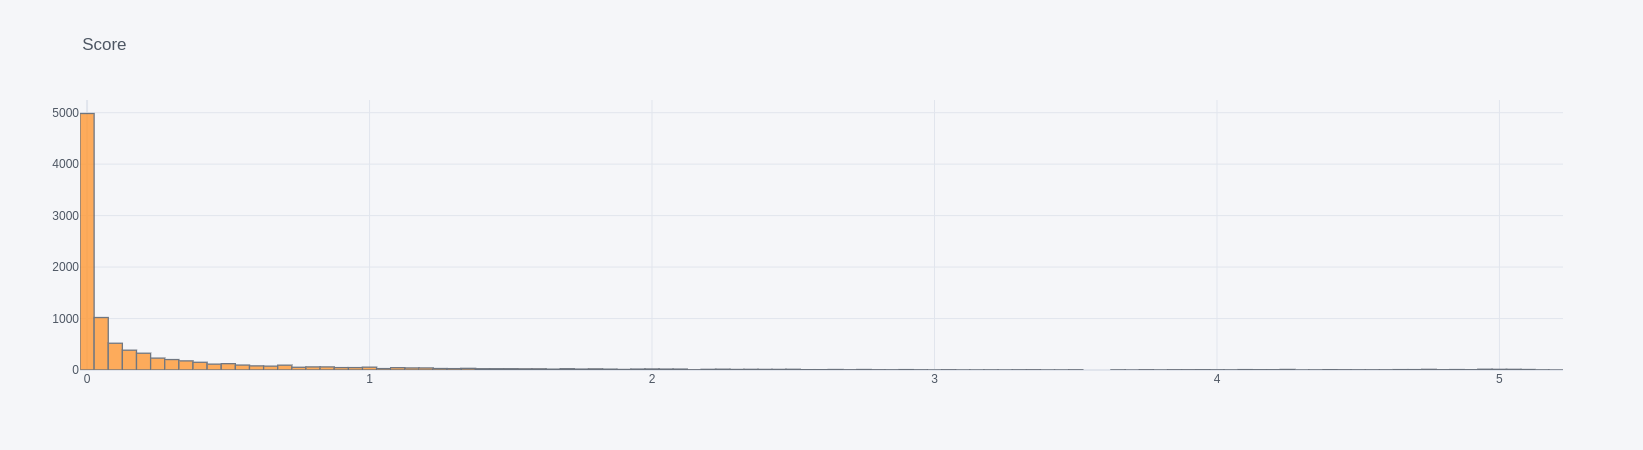

In [554]:
np.log(1 + df['score'].replace(0, np.nan).dropna()).iplot(kind='histogram', title='Score')

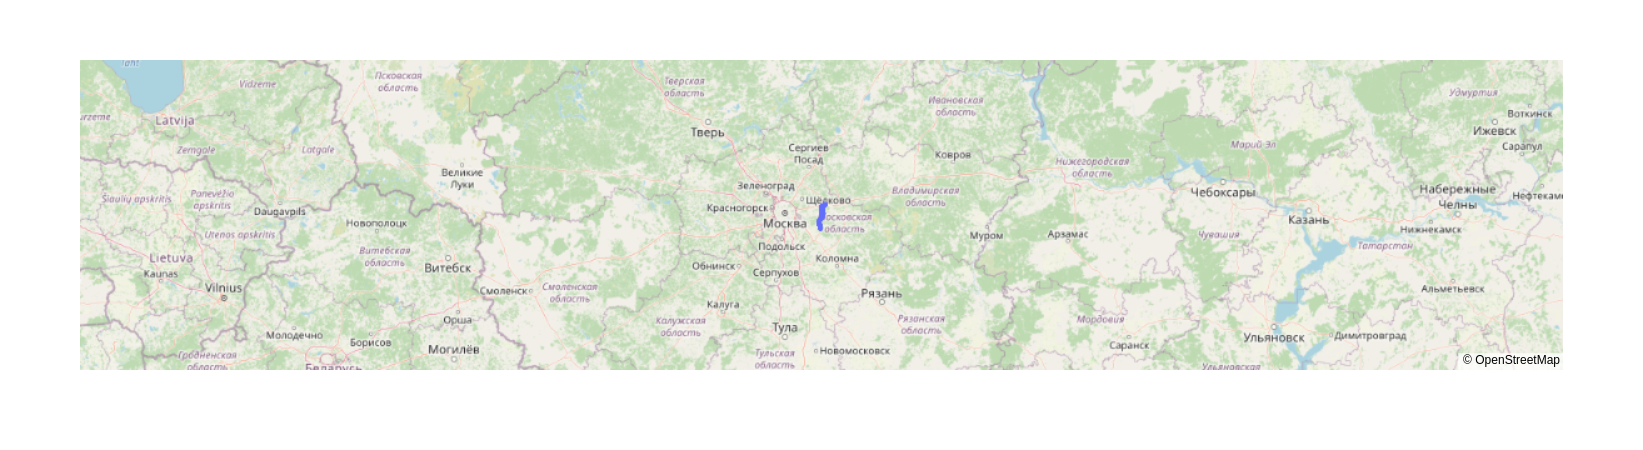

In [557]:
# rand_vin = choice(df.reset_index()['car_vin'].unique())
# print(rand_vin)
px.scatter_mapbox(df.loc[rand_vin], lat='lat', lon='lon',
               hover_data=['angle', 'score', 'speed'],
               mapbox_style="open-street-map", zoom=5) 